# Workload

This notebook explores using embeddings for generating a workload that should resemble a internet realistic traffic between several countries. Mainly, ground stations that are close to each other should have a similar distribution of requests while ground stations that are far away from each other should have a very different distribution of requests. Additionally, when crossing conutry borders, the distribution of requests should also abruptly change (e.g. cities in Germany that are 20km apart have a more similar distribution of requests than a city in Germany and a city in France that are also 20km apart).

## LLE example

In [1]:
from sklearn.datasets import load_digits
from sklearn.manifold import LocallyLinearEmbedding

Example for an embedding (Locally Linear Embedding) on NIST data set:

In [2]:
X, _ = load_digits(return_X_y=True)

In [3]:
X.shape

(1797, 64)

In [4]:
embedding = LocallyLinearEmbedding(n_components=2)
X_transformed = embedding.fit_transform(X[:500])
X_transformed.shape

(500, 2)

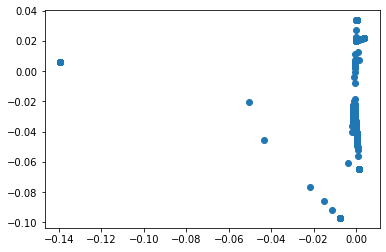

In [5]:
import matplotlib.pyplot as plt
plt.rc('image', cmap='tab10')

fig, ax = plt.subplots()

ax.scatter(x=X_transformed[:,0],y=X_transformed[:,1])

## Data

### Cities

Using coordinates of cities in several European countries as data set for exploration.

In [6]:
import csv
import numpy as np

def read_cities_csv(path):
    dtype = np.dtype([('city', 'str'), ('lat', 'float'), ('long', 'float')])
    with open(path) as f:
        cities = np.array(list(csv.reader(f, delimiter="\t")))
    return cities

Each city is represented by latitude, longitude and a numeric country value.

In [7]:
import os

def load_data(input_dir, filter_keywords=[]):
    files = os.listdir(input_dir)
    X = []
    for i, file in enumerate(files):
        cities = read_cities_csv(os.path.join(input_dir, file))
        
        # Filter cities by keyword, e.g. to remove former colonies
        filter_arr = []
        for name, lat, long in cities:
            if any([(kw in name) for kw in filter_keywords]):
                filter_arr.append(False)
            else:
                filter_arr.append(True)
        cities = cities[filter_arr]
        
        X_i = cities[:,1:]
        X_i = np.c_[X_i, np.full(X_i.shape[0], i)]
        X.append(X_i)
    return np.vstack(X).astype(np.float64)

In [8]:
X = load_data("cities/", filter_keywords=["Reunion", "Réunion", "Cayenne"])

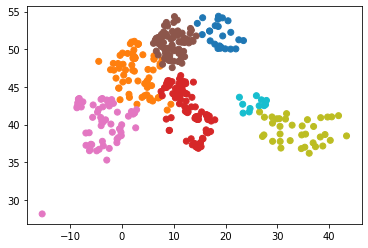

In [9]:
fig, ax = plt.subplots()

ax.scatter(x=X[:,1], y=X[:,0], c=X[:,2])

Normalize coordinates and one-hot-encode country value:

In [10]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num_cols = [0, 1]
cat_cols = [2]
pipeline = ColumnTransformer([
        ("num_transformer", StandardScaler(), num_cols),
        ("cat_transformer", OneHotEncoder(), cat_cols)
    ])
X = pipeline.fit_transform(X)

In [49]:
one_hot_enc = pipeline.transformers_[1][1]
c = one_hot_enc.inverse_transform(X[:,2:])

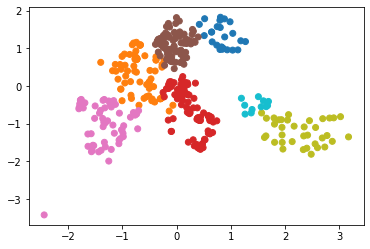

In [12]:
fig, ax = plt.subplots()

ax.scatter(x=X[:,1], y=X[:,0], c=c)

## Embeddings

### LLE

In [13]:
lle = LocallyLinearEmbedding(n_components=2)
X_transformed = lle.fit_transform(X)

LLE does unfortunately not result in a useful embedding as the cities are not evenly distributed and concentrated around small areas:

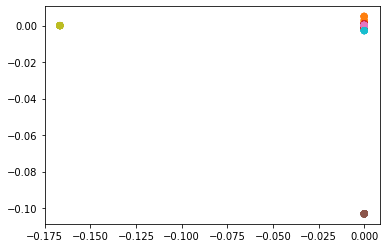

In [14]:
fig, ax = plt.subplots()

ax.scatter(x=X_transformed[:,0], y=X_transformed[:,1], c=c)

### TSNE

Trying out alternative: TSNE

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_transformed_tsne = tsne.fit_transform(X)

Looks very promising, as countries more or less retain their relative distances (e.g. Turkish cities and Bulgarian cities are still close) and differences between countries are accentuated:

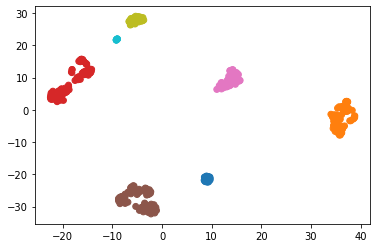

In [16]:
fig, ax = plt.subplots()

ax.scatter(x=X_transformed_tsne[:,0], y=X_transformed_tsne[:,1], c=c)

### UMAP

As explained [here](https://towardsdatascience.com/how-exactly-umap-works-13e3040e1668), tSNE does not preserve global structure well, so the inter-cluster distances don't really have any meaning. UMAP does preserve these distances which makes it very suitable for our use-case.

This visualization describes the issue with tSNE for global structures:

![tSNE Global Structure](https://miro.medium.com/max/1400/1*ATjXEIvi-p8OLzDYNvPmew.png)

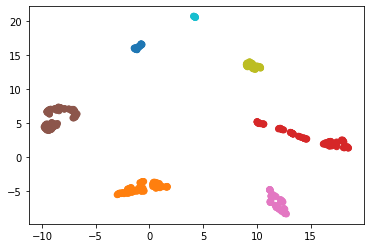

In [107]:
import umap

reducer = umap.UMAP()
X_transformed_umap = reducer.fit_transform(X)
fig, ax = plt.subplots()

ax.scatter(x=X_transformed_umap[:,0], y=X_transformed_umap[:,1], c=c)

#### Weight of country

/home/jonas/Projects/LEO-CDN/env/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/jonas/Projects/LEO-CDN/env/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/jonas/Projects/LEO-CDN/env/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/jonas/Projects/LEO-CDN/env/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/jonas/Projects/LEO-CDN/env/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/jonas/Projects/LEO-CDN/env/lib/python3.8/

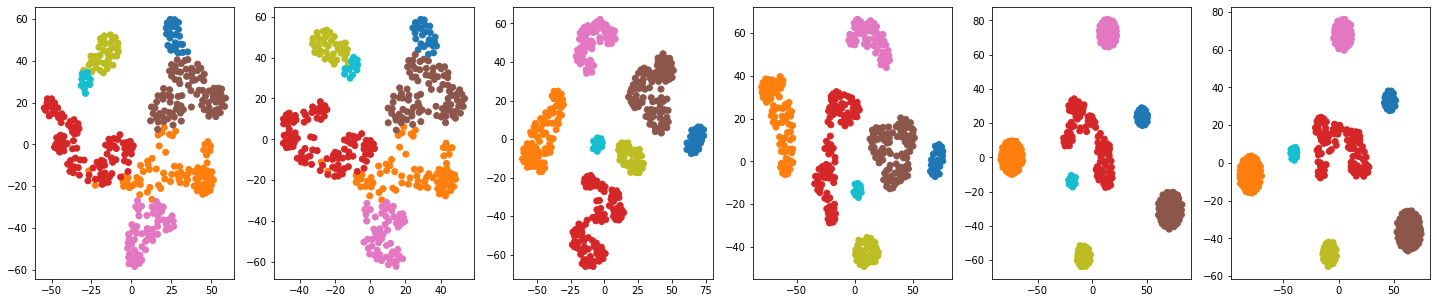

In [112]:
country_weights = [0.000001, 0.001, 1, 100, 100000, 10000000]

fig, axes = plt.subplots(ncols=len(country_weights), figsize=(25, 5))

for ax, cw in zip(axes, country_weights):
    X_scaled = np.c_[X[:,:2], X[:,2:] * cw]
    reducer = umap.UMAP(random_state=42, n_neighbors=100, spread=10, min_dist=5)
    X_transformed_umap = reducer.fit_transform(X_scaled)
    ax.scatter(x=X_transformed_umap[:,0], y=X_transformed_umap[:,1], c=c)

#### `min_dist`

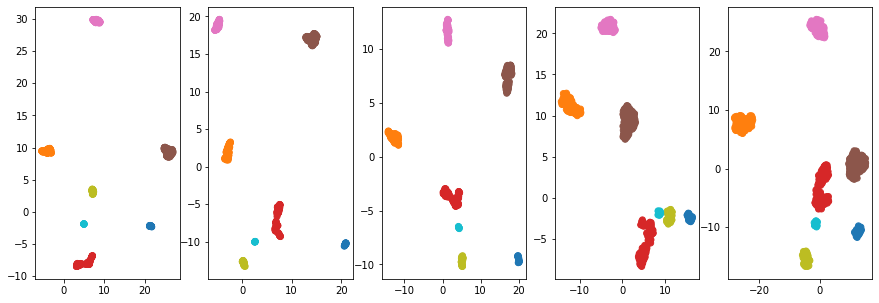

In [57]:
min_dists = [0.001, 0.01, 0.1, 0.5, 1]

fig, axes = plt.subplots(ncols=len(min_dists), figsize=(15, 5))

for ax, min_dist in zip(axes, min_dists):
    reducer_md = umap.UMAP(min_dist=min_dist, n_neighbors=100)
    X_transformed_umap_min_md = reducer_md.fit_transform(X)

    ax.scatter(x=X_transformed_umap_min_md[:,0], y=X_transformed_umap_min_md[:,1], c=c)

#### `spread`

/home/jonas/Projects/LEO-CDN/env/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/jonas/Projects/LEO-CDN/env/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


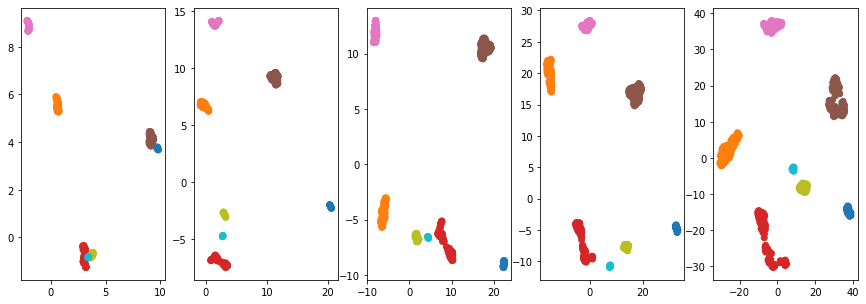

In [56]:
spreads = [0.1, 0.5, 1, 2, 5]

fig, axes = plt.subplots(ncols=len(spreads), figsize=(15, 5))

for ax, spread in zip(axes, spreads):
    reducer_sp = umap.UMAP(spread=spread, n_neighbors=100)
    X_transformed_umap_min_sp = reducer_sp.fit_transform(X)

    ax.scatter(x=X_transformed_umap_min_sp[:,0], y=X_transformed_umap_min_sp[:,1], c=c)

## File popularity

In [20]:
X_transformed = X_transformed_umap

### Files grid

To reflect these positions in the popularity of files, the embedding is projected on a "file grid": files are evently distributed over the embedding space and files that are close to a gorund station are very popular there:

In [21]:
xmin = np.min(X_transformed[:,0])
xmax = np.max(X_transformed[:,0])

ymin = np.min(X_transformed[:,1])
ymax = np.max(X_transformed[:,1])

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
positions

array([[-17.55266953, -17.55266953, -17.55266953, ...,  19.59624481,
         19.59624481,  19.59624481],
       [-10.48074055, -10.15196539,  -9.82319024, ...,  21.41044953,
         21.73922468,  22.06799984]])

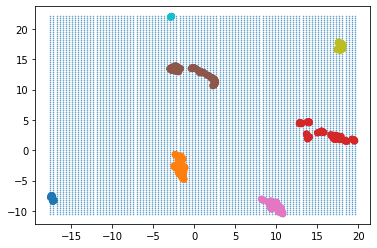

In [22]:
fig, ax = plt.subplots()

ax.scatter(x=positions[0], y=positions[1], s=0.3, alpha=0.7)
ax.scatter(x=X_transformed[:,0], y=X_transformed[:,1], c=c)

### Distance to files

In [23]:
def calculate_distance_to_files(gst_coords, files_coords):
    dists = []
    for f_coords in files_coords.T:
        d = np.linalg.norm(gst_coords - f_coords)
        dists.append(d)
    return np.array(dists)

In [24]:
gst_coords = X_transformed[0][:2]
D = calculate_distance_to_files(gst_coords, positions)

Red files represent files that are popular in the ground station, blue ones are unpopular

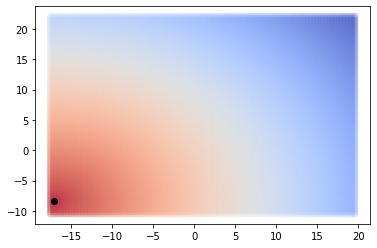

In [25]:
fig, ax = plt.subplots()

ax.scatter(x=positions[0], y=positions[1], c=D, alpha=0.2, cmap="coolwarm_r")
ax.scatter(x=gst_coords[0], y=gst_coords[1], c="black")

The file order will be used for determining which files are popular:

In [26]:
file_order = D.argsort()
D[file_order]

array([ 0.13967357,  0.189141  ,  0.3980281 , ..., 47.44511991,
       47.52461817, 47.73358072])

In [27]:
file_order

array([ 106,  107,  206, ..., 9899, 9998, 9999])

## Random distributions

### Zipf (Zeta) distribution

Looks a bit too concentrated around 1 or 2 f

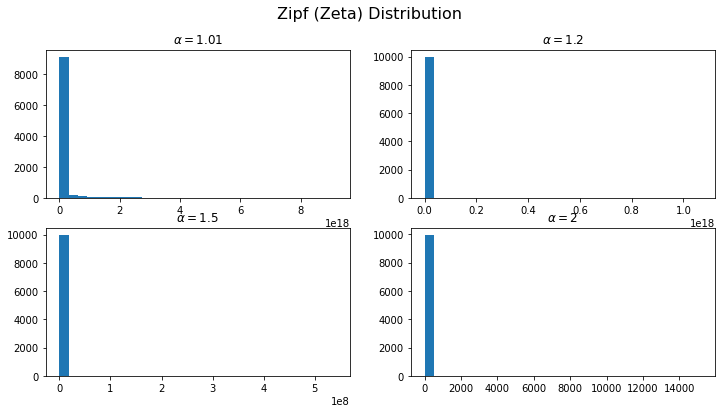

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
params = [1.01, 1.2, 1.5, 2]

fig.suptitle("Zipf (Zeta) Distribution", fontsize=16)
for i, ax in enumerate(axes.flat):
    a = params[i]
    x = np.random.zipf(a, 10000)
    ax.hist(x, bins=30)
    ax.set_title(fr"$\alpha={a}$")

### Geometric distribution

Might resemble realistic internet traffic quite well:

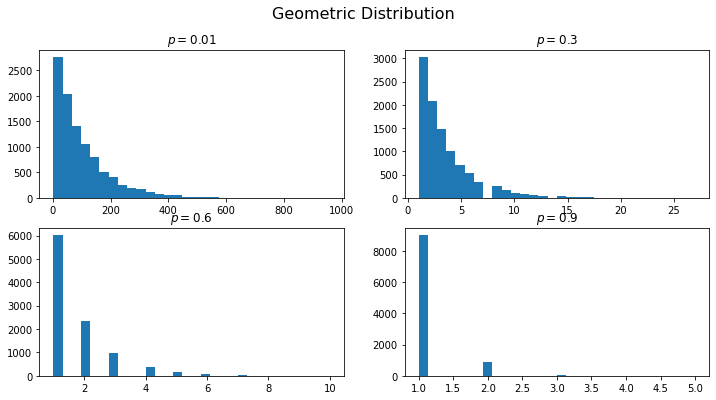

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
params = [0.01, 0.3, 0.6, 0.9]

fig.suptitle("Geometric Distribution", fontsize=16)
for i, ax in enumerate(axes.flat):
    p = params[i]
    x = np.random.geometric(p, 10000)
    ax.hist(x, bins=30)
    ax.set_title(fr"$p={p}$")

## Generalize to 3D case

Since the earth is a globe and not a plane this has to be generalized to the 3D case. In order to do this, the ground stations lat-long (2D) coordinates have to be proected to 3D xyz coordinates.

The embedding would then project from (x, y, z, country) to (a, b, c)

In [30]:
import math

EARTH_RADIUS = 6371000  # in meter
ALTITUDE = 550  # Orbit Altitude (Km)

# according to wikipedia
STD_GRAVITATIONAL_PARAMETER_EARTH = 3.986004418e14
# seconds the earth needs to make one whole rotation
SECONDS_PER_DAY = 60 * 60 * 24
# earth's z axis (eg a vector in the positive z direction)
EARTH_ROTATION_AXIS = [0, 0, 1]  # this means the north pole is on the top and the south pole is on the bottom
SEMI_MAJOR_AXIS = float(ALTITUDE) * 1000 + EARTH_RADIUS

def transform_geo_to_xyz(lat, lon):
    """
    Transforms any latitude and longitude to xyz coordinates.
    Taken from Ben S. Kempton.
    Parameters
    ----------
    lat
    lon

    Returns
    -------

    """
    # must convert the lat/long/alt to cartesian coordinates
    radius = EARTH_RADIUS + ALTITUDE
    init_pos = [0, 0, 0]
    latitude = math.radians(lat)
    longitude = math.radians(lon)
    init_pos[0] = radius * math.cos(latitude) * math.cos(longitude)  # x
    init_pos[1] = radius * math.cos(latitude) * math.sin(longitude)  # y
    init_pos[2] = radius * math.sin(latitude)  # z

    pos = init_pos

    x = np.int32(pos[0])
    y = np.int32(pos[1])
    z = np.int32(pos[2])

    return x, y, z

In [31]:
def row_transform_geo_to_xyz(row):
    lat = row.lat
    lon = row.lng
    return transform_geo_to_xyz(lat, lon)

Using world city data from https://simplemaps.com/data/world-cities

### Load world city data

In [32]:
import pandas as pd

df_cities = pd.read_csv("simplemaps_worldcities_basicv1.73/worldcities.csv")

In [33]:
df_cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,Delhi,admin,29617000.0,1356872604
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,Mahārāshtra,admin,23355000.0,1356226629
4,Manila,Manila,14.5958,120.9772,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140


### Tranform lat/lon to xyz coordinates

In [34]:
df_cities["x"], df_cities["y"], df_cities["z"] = zip(*df_cities.apply(row_transform_geo_to_xyz, axis=1))

In [35]:
df_cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id,x,y,z
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764,-3946275,3347609,3717131
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077,-1835530,6062321,-689737
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,Delhi,admin,29617000.0,1356872604,1235804,5452625,3055865
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,Mahārāshtra,admin,23355000.0,1356226629,1778479,5757182,2070872
4,Manila,Manila,14.5958,120.9772,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140,-3173582,5286492,1605620


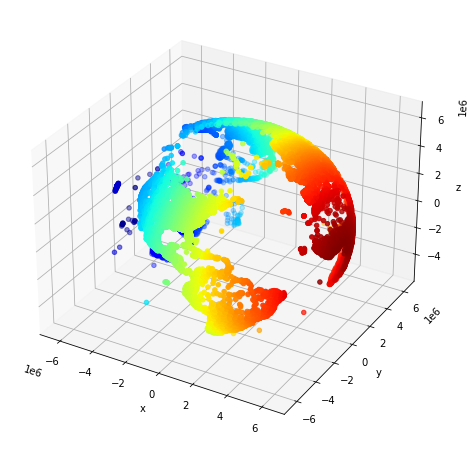

In [36]:
fig, ax = plt.subplots(subplot_kw=dict(projection="3d"), figsize=(12, 8))

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

xs = df_cities.x
ys = df_cities.y
zs = df_cities.z

c = df_cities.population

ax.scatter(
    xs,
    ys,
    zs,
    c=xs,
    cmap="jet"
)

### Apply embedding to xyz coordinates

In [42]:
reducer = umap.UMAP(n_components=3, n_neighbors=100)

X_3d_raw = df_cities[["x", "y", "z", "iso2"]].to_numpy()

In [43]:
num_cols_3d = [0, 1, 2]
cat_cols_3d = [3]
pipeline_3d = ColumnTransformer([
        ("num_transformer", StandardScaler(), num_cols_3d),
        ("cat_transformer", OneHotEncoder(), cat_cols_3d)
    ])
X_3d = pipeline_3d.fit_transform(X_3d_raw)
# X_3d[:,3:] = X_3d[:,3:] * 1000

In [44]:
X_3d_umap = reducer.fit_transform(X_3d)

In [45]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()
c = label_enc.fit_transform(X_3d_raw[:,3])

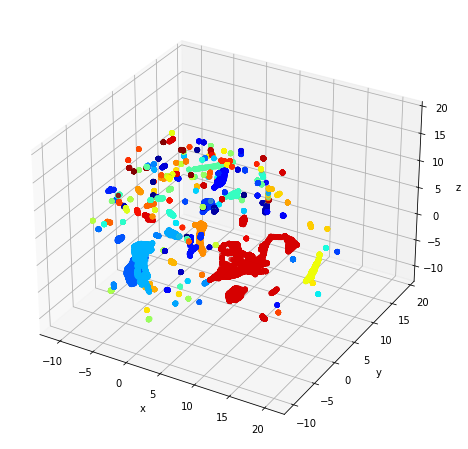

In [46]:
fig, ax = plt.subplots(subplot_kw=dict(projection="3d"), figsize=(12, 8))

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

xs = X_3d_umap[:,0]
ys = X_3d_umap[:,1]
zs = X_3d_umap[:,2]

ax.scatter(
    xs,
    ys,
    zs,
    c=c,
    cmap="jet"
)